In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import struct
import os

In [ ]:
# creating a class for the CNN containing all the functions required
class CNN(nn.Module):

  ## defining the constructor of the parent class - nn.Module
  def __init__(self, in_channels=1, num_classes=10):
    # calling the constructor of the parent class - nn.Module
    super(CNN, self).__init__()

    ## defining the layers of the CNN

    # here, input channel = 1, since input image is greyscale, hence one color channel
    # output channels = 8, which is number of filters applied, and each filter is of 3*3*1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # "same" convolution
    # o/p dimensions  - (28*28*8)

    self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # o/p dimensions - (14*14*8)

    # here, input channels = 8 = prev output channels, and num of filters = 16 = output channels
    # o/p dimensions  - (14*14*16)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) # "same" convolution

    self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) # o/p dimensions - (7*7*16)

    # fully connected layer with num of inp neurons = 7*7*16, and num of o/p neurons = 10
    self.fc1 = nn.Linear(16*7*7, 128)
    self.fc2 = nn.Linear(128, num_classes)

  ## defining the forward propagation of the CNN
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.reshape(x.shape[0], -1) # to flatten out for the fully connected layer
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

In [ ]:
# check accuracy with train set and/or test set
def check_accuracy(loader, model, i):
  # setting the model to eval mode - regularisation, normalisation is stopped.
  model.eval()
  num_correct = 0
  num_samples = 0

  with torch.no_grad():
    for data, targets in loader:
      data = data.to(device=device)
      targets = targets.to(device=device)
      #data = data.reshape(data.shape[0], -1)

      predictions = model(data)
      _, predictions = predictions.max(1)
      num_correct += (predictions == targets).sum()
      num_samples += predictions.size(0)

  acc  = float(num_correct)/float(num_samples)*100
  print(f"Accuracy after epoch {i}: {float(acc):.2f}\n")
  model.train() # setting back model to train mode.
  return acc


Cost after epoch 1: 1.3395786987522902
Accuracy after epoch 1: 86.70

Cost after epoch 2: 0.3449328460935819
Accuracy after epoch 2: 92.20

Cost after epoch 3: 0.2340104597604881
Accuracy after epoch 3: 94.44

Cost after epoch 4: 0.17486204030150074
Accuracy after epoch 4: 95.58

Cost after epoch 5: 0.1356302586905027
Accuracy after epoch 5: 96.58

Cost after epoch 6: 0.11174347390562801
Accuracy after epoch 6: 96.99

Cost after epoch 7: 0.09824353557522014
Accuracy after epoch 7: 97.49

Cost after epoch 8: 0.086696877254773
Accuracy after epoch 8: 97.64

Cost after epoch 9: 0.07747090828873343
Accuracy after epoch 9: 97.87

Cost after epoch 10: 0.06993478523977732
Accuracy after epoch 10: 98.02

Cost after epoch 11: 0.06543254498708045
Accuracy after epoch 11: 97.86

Cost after epoch 12: 0.061428426433417754
Accuracy after epoch 12: 98.02

Cost after epoch 13: 0.056371538884053794
Accuracy after epoch 13: 98.19

Cost after epoch 14: 0.05213029152255947
Accuracy after epoch 14: 98.18



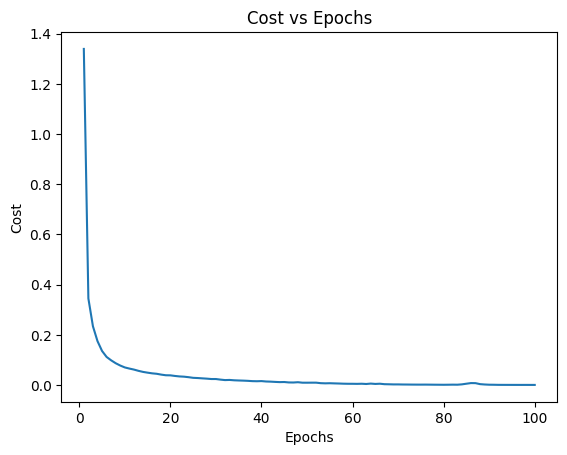

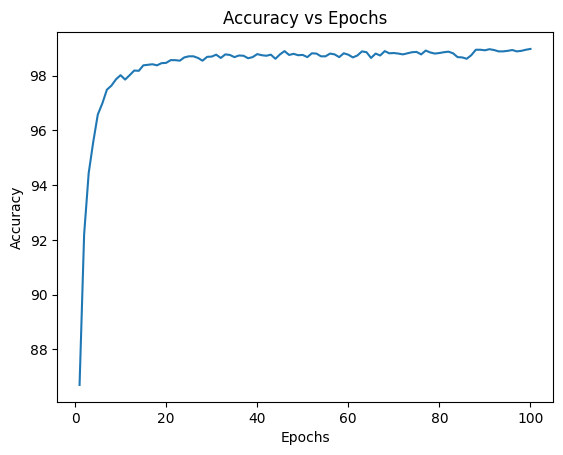

In [ ]:
# to specify the device which which process the tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 1024
num_epochs = 100


# load data
def load_images(path):
    with open(path, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        # reshaped to 4D array - (nun of img, num of color channel, height, width of each img)
        images = np.fromfile(f, dtype=np.uint8).reshape(num, 1, rows, cols)
        # numpy array converted to pytorch tensor
        images = torch.tensor(images, dtype=torch.float32)/255.0 # to normalise to [0, 1]
    return images

def load_labels(path):
    with open(path, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        # numpy array of 8-bit unsigned ints
        labels = np.fromfile(f, dtype=np.uint8)
        # numpy array converted to a PyTorch tensor, with datatype = long
        labels = torch.tensor(labels, dtype=torch.long)
    return labels

train_x = load_images("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/train-images.idx3-ubyte")
train_y = load_labels("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/train-labels.idx1-ubyte")
test_x = load_images("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/t10k-images.idx3-ubyte")
test_y = load_labels("/content/drive/MyDrive/IvLabs VNIT/MNIST Task Dataset/t10k-labels.idx1-ubyte")

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

# below, shuffle=True so that we dont have same set of images in a batch in every epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# initialising the network by creating an instance of the class CNN
model = CNN().to(device)

# loss function
# CrossEntropyLoss function implicitly applies softmax first, then calculates negative log likelihood loss
# hence we need not call the softmax function explicitly.
loss_func = nn.CrossEntropyLoss()


# Adam Optimiser
# model.parameters() to retrieve all the parameters of a NN model
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

# training the network
cost_lst = []
accu_lst = []
for epoch in range(num_epochs):

  loss_epoch = 0
  for batch_index, (data, targets) in enumerate(train_loader):
    data = data.to(device=device)
    targets = targets.to(device=device)

    # forward propagation
    predictions = model(data)
    loss = loss_func(predictions, targets)
    loss_epoch += loss.item()

    # backward propagation
    optimiser.zero_grad() # zero_grad to set gradients back to 0 after every batch
    loss.backward() # weight updation

    # gradient descent through adam optimiser algo
    optimiser.step()

  cost_epoch = loss_epoch/len(train_loader)
  cost_lst.append(cost_epoch)
  # printing the cost after every epoch
  print(f"Cost after epoch {epoch+1}: {cost_epoch}")

  # checking accuracy after every epoch
  accu = check_accuracy(test_loader, model, epoch+1)
  accu_lst.append(accu)


t = np.arange(1, num_epochs+1)
plt.plot(t, cost_lst)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Cost vs Epochs")
plt.show()

plt.plot(t, accu_lst)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()